In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *

In [3]:
# from sensetools.plots import feature_labeller

In [4]:
protein = '1fme'
md_t2 = {'1fme': 18*1000}
# order = [(53, 'fixed_k'), (60, 'fixed_k'), (52, 'fixed_k'), (47, 'worst'), (81, 'timescale_gap'), (60, 'timescale_gap'), (86, 'timescale_gap')]
lag = 41

In [5]:
summary_path = f'{protein}/summary.h5'

# selection = pd.read_hdf(summary_path, key='model_selection')
timescales = pd.read_hdf(summary_path, key='timescales')
vamps = pd.read_hdf(summary_path, key='vamps')
gaps = pd.read_hdf(summary_path, key='timescale_ratio')
gaps.reset_index(inplace=True)
timescales.reset_index(inplace=True)
vamps.reset_index(inplace=True)

In [6]:
def feature_labeller(x): 
    if x['feature__value'] == 'dihedrals': 
        return 'dihedrals'
    elif x['feature__value'] == 'distances': 
        return f"{x['distances__transform']}-distances"

In [7]:
hp_samples = pd.read_hdf('../experiments/hpsample.h5')

hp_samples.reset_index(inplace=True)

hp_samples['feature'] = hp_samples.apply(feature_labeller, axis=1)
vamps = vamps.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')
timescales = timescales.merge(hp_samples.loc[:, ['feature', 'hp_ix']], on='hp_ix')

In [8]:
def top_performers_by_feature(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median', 'feature']].copy()
    df['rank'] = df.groupby(['feature'])['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def top_performers(vamps: pd.DataFrame, k: int, lag: int)-> Dict[int, int]:
    df = vamps.loc[(vamps.process==k) & (vamps.lag==lag), ['hp_ix', 'median']].copy()
    df['rank'] = df['median'].rank(ascending=False)
    df.sort_values(by='rank', inplace=True)
    d = dict(zip(df['hp_ix'], df['rank']))
    return d


def plot_val_by_mod_proc(ax, value_df, color='by_proc'): 
    for (mod_n, proc), df in value_df.groupby(['rank', 'process']):
        if mod_n == 1: 
            label = f"{proc}"
        else: 
            label = None
        
        if color=='by_proc':
            col = cols[proc-2]
        else: 
            col = color
#         if proc == 2: 
#             print(mod_n, df['median'])
        ax.hlines(df['median'],  mod_n-width, mod_n+width, color=col, label=label, lw=3)
        
        ax.fill_between([mod_n-width, mod_n+width], df['lb'], df['ub'], alpha=0.05, color=col)


## Select incongruous models

In [37]:
# Select observables and vamp scores
k = 2

top_vamps = vamps.loc[(vamps.process==k) & (vamps.lag==lag), :].copy()
top_timescales = timescales.loc[(timescales.lag == lag) & (timescales.process==k), :].copy()

# rank models
rank_by_ix = top_performers(vamps, k=k, lag=lag)

# add ranks to observables/vamps
top_vamps[f'rank'] = top_vamps['hp_ix'].apply(lambda x: rank_by_ix.get(x))
top_timescales[f'rank'] = top_timescales['hp_ix'].apply(lambda x: rank_by_ix.get(x))


In [42]:
top_timescales.sort_values(by=['rank'], inplace=True)
bad_ix = []
for i, row1 in top_timescales.iterrows():
    ts = row1['median']
    rank = row1['rank']
    ix = row1['hp_ix']
    
    tmp = []
    for j, row2 in top_timescales.loc[top_timescales['rank']>rank, :].iterrows(): 
        if row2['median'] > ts: 
            tmp.append(row2['hp_ix'])
            
    if len(tmp)>0: 
        tmp.append(ix)
        tmp = [tmp[-1]] + tmp[:-1]
        bad_ix.append(tuple(tmp))

sort_ix = np.argsort([len(x) for x in bad_ix])[::-1]
bad_ix_sorted = [bad_ix[i] for i in sort_ix]

In [43]:
bad_ix_sorted

[(147,
  37,
  133,
  139,
  34,
  72,
  264,
  54,
  170,
  89,
  93,
  184,
  47,
  289,
  91,
  151,
  242,
  104,
  228,
  26,
  254),
 (30,
  89,
  73,
  93,
  184,
  47,
  230,
  289,
  91,
  199,
  151,
  242,
  313,
  206,
  182,
  104,
  228,
  101,
  26,
  254),
 (60,
  139,
  34,
  72,
  264,
  54,
  170,
  89,
  93,
  184,
  47,
  289,
  91,
  151,
  242,
  104,
  228,
  26,
  254),
 (57,
  73,
  93,
  184,
  47,
  230,
  289,
  91,
  199,
  151,
  242,
  313,
  206,
  182,
  104,
  228,
  101,
  26,
  254),
 (44, 7, 89, 93, 184, 47, 289, 91, 151, 242, 313, 206, 182, 104, 228, 26, 254),
 (144, 264, 54, 170, 89, 93, 184, 47, 289, 91, 151, 242, 104, 228, 26, 254),
 (202, 242, 6, 102, 39, 313, 206, 87, 182, 186, 104, 228, 217, 101, 26, 254),
 (73, 93, 184, 47, 289, 91, 151, 242, 313, 206, 182, 104, 228, 101, 26, 254),
 (11, 199, 5, 151, 242, 6, 313, 206, 182, 104, 228, 217, 101, 26, 254),
 (139, 34, 264, 54, 170, 93, 184, 289, 91, 151, 242, 104, 228, 26),
 (69, 91, 199, 151, 2

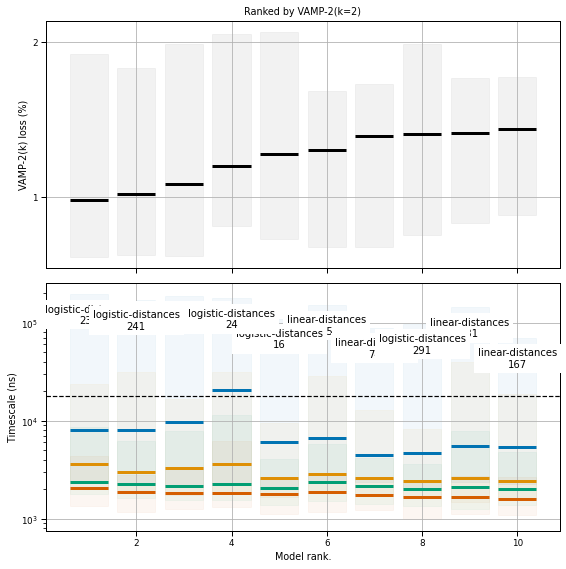

In [9]:
top_n = 10

# for k in range(2, 4):


# rescale score
top_vamps['median'] = 100*(1-top_vamps['median']/k)
top_vamps['lb'] = 100*(1-top_vamps['lb']/k)
top_vamps['ub'] = 100*(1-top_vamps['ub']/k)

with sns.plotting_context('paper', font_scale=1): 
    width =0.4
    offset = 0.5
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    cols = sns.color_palette('colorblind', timescales.process.max())

    vamp_ax = axes[0]

    plot_val_by_mod_proc(vamp_ax, top_vamps.query(f"rank <= {top_n}"), color='k')
    vamp_ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    vamp_ax.set_ylabel('VAMP-2(k) loss (%)')
#         axes[0].set_yscale('log')

    time_ax = axes[1]
    plot_val_by_mod_proc(time_ax, top_timescales.query('process <= 5').query(f"rank <= {top_n}"))
    time_ax.set_yscale('log')
    time_ax.set_ylabel('Timescale (ns)')
    for ix, df in top_timescales.query(f"rank <= {top_n}").query('process == 2').iterrows(): 
        time_ax.annotate(text=f"{df.feature}\n{df.hp_ix}", xy=(df['rank'], df.ub*0.8), 
                         verticalalignment='top', 
                          horizontalalignment='center', bbox={'facecolor': 'white', 'linewidth': 0}, fontsize=10)

    xlim = time_ax.get_xlim()    
    time_ax.hlines(md_t2[protein], *xlim, color='k',ls='dashed')
    time_ax.set_xlim(xlim)

    axes[-1].set_xlabel('Model rank.')
    axes[0].set_title(f'Ranked by VAMP-2(k={k})')
#         axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
    axes[0].grid()
    axes[1].grid()
    for ax in axes.flatten():
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

    plt.tight_layout()
    # plt.savefig(f'{protein}/{protein}_timescale_comarison_by_rank_k_{k}.png', bbox_inches='tight')